<a href="https://colab.research.google.com/github/gennadygorin/GP_2023_2/blob/main/GP_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New & Notable: Quantifying and correcting bias in transcriptional parameter inference from single-cell data

In this notebook, we revisit some key results from the Grima & Esmenjaud article published in *Biophysical Journal*, 2023. We generate synthetic data coupled through a particular extrinsic noise source, then attempt to "denoise" it. How well will normalization work?

In [ ]:
import numpy as np
from numpy import matlib
import scipy
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(2813308004)

In [ ]:
nc = 500 # number of cells
ng = 100 # number of genes

The mixing distribution involves a parameter $V$, which is related to the volume. We assume this distribution is gamma, with shape $\nu$ and mean $\langle V \rangle = 1$. Then, for each gene $g$ and cell $c$, the burst size is $b_{cg} = r_g V_c$, a linear dependence.

The parameters are somewhat arbitrary, but Grima and Esmenjaud assume $\nu>1$, which produces a distribution with a nonzero mode (matching typical regulatory macromolecule distributions), so we choose a consistent parameter.

In [ ]:
nu = 2.1 # shape parameter for mixing distribution
sc = 1/nu
V = np.random.gamma(nu,sc,nc)

Next, we select $r_g$ and $k_g/\gamma_g$ values. We draw these from somewhat arbitrary gamma distributions.

In [ ]:
b_scale = np.random.gamma(1,4,ng)
tx_rate = np.random.gamma(2,.5,ng)

Multiplying $r_g$ by $V_c$, we obtain the burst sizes. To sample from the negative binomial distribution, which describes the bursting physics, we convert $b_{cg}$ to probabilities.

In [ ]:
bs = np.outer(V,b_scale)
p = 1/(1+bs)
k = np.matlib.repmat(tx_rate,nc,1)

In [ ]:
X = np.random.negative_binomial(k,p)

Although all genes' transcription processes are independent, the data show meaningful correlations due to extrinsic noise coupling.

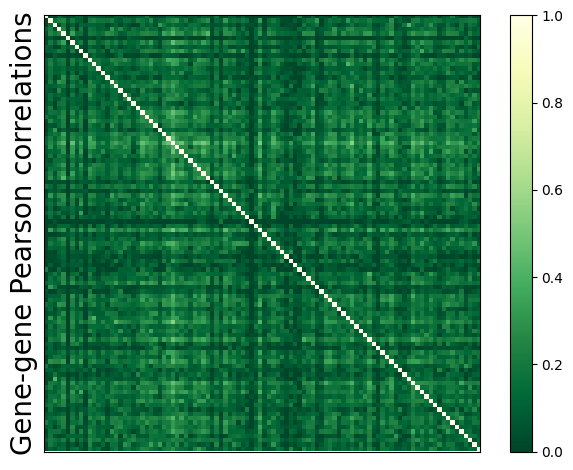

In [ ]:
fig1=plt.figure(figsize=[6.4, 4.8])
plt.imshow(np.corrcoef(X.T),cmap='YlGn_r',vmin=0,vmax=1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.ylabel('Gene-gene Pearson correlations',fontsize=20)
fig1.tight_layout()
plt.savefig('corrs_raw.png',dpi=450)

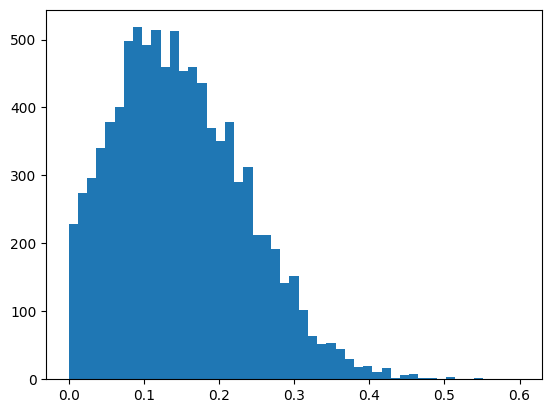

In [ ]:
_=plt.hist(np.corrcoef(X.T).flatten(),bins = np.linspace(0,.6))

The averages are consistent with the theoretical values plugged into simulation.

Text(0.5, 0, '$\\langle m_i\\rangle$')

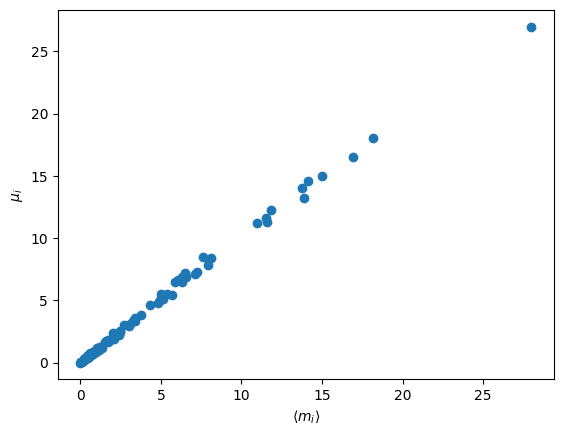

In [ ]:
plt.scatter(X.mean(0),tx_rate*b_scale)
plt.ylabel(r'$\mu_i$')
plt.xlabel(r'$\langle m_i\rangle$')

In [ ]:
data_cov = np.cov(X.T)
data_mean_products = np.outer(X.mean(0),X.mean(0))
coupling_strength = 1/nu

The covariances between genes is proportional to the individual genes' expression. The proportionality is related to the true coupling strength or CV$^2$ of the extrinsic noise distribution, $\nu^{-1}$, in red.

Text(0.5, 0, '$\\langle m_i\\rangle\\langle m_j\\rangle$')

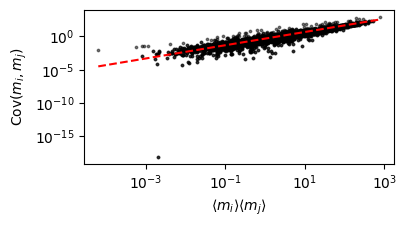

In [ ]:
fig1 = plt.figure(figsize=(4,2))
plt.scatter(data_mean_products.flatten(),data_cov.flatten(),3,'k',alpha=0.5)
x = np.linspace(data_mean_products.min(),data_mean_products.max())
plt.plot(x,x*coupling_strength,'r--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'Cov($m_i,m_j$)')
plt.xlabel(r'$\langle m_i\rangle\langle m_j\rangle$')


We can fit this value fairly closely.

In [ ]:
pf = np.polyfit(data_mean_products.flatten(),data_cov.flatten(),1)
CVV2_pf = pf[0]
print(CVV2_pf)
print(coupling_strength)


0.4910755653846881
0.47619047619047616


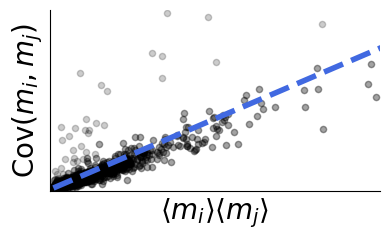

In [ ]:
fig1,ax1 = plt.subplots(1,1,figsize=(4,2.5))
ax1.scatter(data_mean_products.flatten(),data_cov.flatten(),20,'k',alpha=0.2)
x = np.linspace(data_mean_products.min(),data_mean_products.max())
ax1.plot(x,x*CVV2_pf,'--',linewidth=4,color='royalblue')
ax1.set_xlim([-4,400])
ax1.set_ylim([-4,250])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel(r'Cov($m_i,m_j$)',fontsize=20)
ax1.set_xlabel(r'$\langle m_i\rangle\langle m_j\rangle$',fontsize=20)
fig1.tight_layout()
plt.savefig('cov_fit.png',dpi=450,transparent=True)

As we have assumed the extrinsic noise comes from a distribution with unity scale, we can use fairly simple moment-based calculations to find the burst size scaling $r_g$ and the burst frequency $k_g/\gamma_g$.

In [ ]:
mu = X.mean(0)
XCv2 = X.var(0)/mu**2

First, recall $\langle V\rangle = 1$ and $b_g := r_g V$, and derive that the noise $\text{CV}^2_{b_g} = \nu^{-1}$ from standard properties of variances.  Solving Equation 15 for $\langle b_g\rangle = r_i$, we obtain

In [ ]:
b_scale_fit = ((XCv2 - CVV2_pf) * mu - 1)/(CVV2_pf+1)

These estimates are coarse, but more or less accurate.

Text(0, 0.5, 'Fit $r_g$')

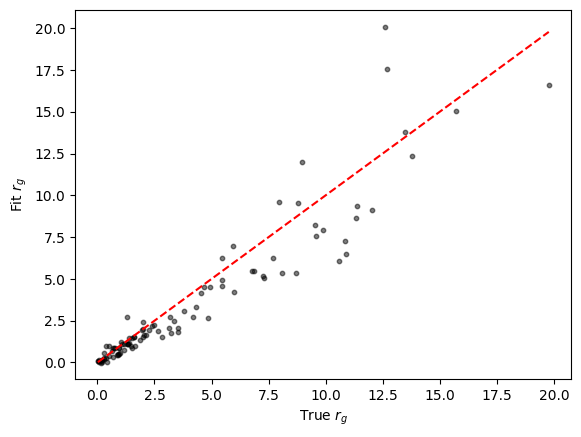

In [ ]:
plt.scatter(b_scale,b_scale_fit,10,'k',alpha=0.5)
x = np.linspace(b_scale.min(),b_scale.max())
plt.plot(x,x,'r--')
plt.xlabel(r'True $r_g$')
plt.ylabel(r'Fit $r_g$')


Then use $\mu_g = \frac{k_g \langle b_g}{\gamma_g}$ to find the burst frequency.

In [ ]:
k_fit = mu/b_scale_fit

Now, normalize the data.

In [ ]:
Y = X/X.sum(1)[:,None]*X.sum(1)[:,None].mean()

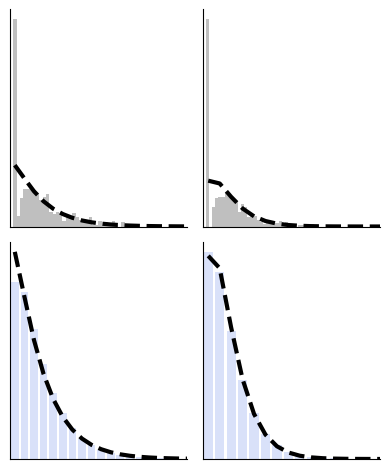

In [ ]:
gi_range = [10,30]
ncol = len(gi_range)
fig1,ax1 = plt.subplots(2,ncol,figsize=(ncol*2,4.8))
for axl,gi in enumerate(gi_range):
    bins2 = np.linspace(-0.5,Y[:,gi].max()-2,40)
    ax1[0,axl].hist(Y[:,gi],bins2,facecolor='gray',alpha=0.5,density=True)

    x = np.arange(X[:,gi].max()-2)
    nb = scipy.stats.nbinom(tx_rate[gi],1/(1+b_scale[gi]))
    y = nb.pmf(x)
    ax1[0,axl].plot(x,y,'k--',linewidth=3)
    ax1[0,axl].set_xlim(-0.5,x[-1])

    x = np.arange(X[:,gi].max()-2)
    nb = scipy.stats.nbinom(k_fit[gi],1/(1+b_scale_fit[gi]))
    y = nb.pmf(x)
    ax1[1,axl].bar(x,y,facecolor='royalblue',alpha=0.2)

    x = np.arange(X[:,gi].max()-2)
    nb = scipy.stats.nbinom(tx_rate[gi],1/(1+b_scale[gi]))
    y = nb.pmf(x)
    ax1[1,axl].plot(x,y,'k--',linewidth=3)
    ax1[1,axl].set_xlim(-0.5,x[-1])

    ax1[0,axl].set_xticks([])
    ax1[0,axl].set_yticks([])

    ax1[1,axl].set_xticks([])
    ax1[1,axl].set_yticks([])

    ax1[1,axl].spines['top'].set_visible(False)
    ax1[1,axl].spines['right'].set_visible(False)
    ax1[0,axl].spines['top'].set_visible(False)
    ax1[0,axl].spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('reconstr.png',dpi=450)

Recall that, by definition, there *is* a well-defined noise-free distribution: it is the negative binomial with burst size $r_g$, i.e., the case where $V = \langle V \rangle = 1$. If normalization purports to remove the size effect, we should expect it to recapitulate this distribution. However, it does not succeed in doing so.

On the other hand, the estimate of $r_g$ obtained by moment-matching is coarse, but fairly accurate and produces a good match to the underlying noise-free distribution when combined with the data from the mean.